In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import numpy as np
from transformers import BertTokenizer, BertModel
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample

/home/maali/.pyenv/versions/3.10.6/envs/VAK_ML/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('/home/maali/code/3Maali/VAK_ML/raw_data/dataset.csv')

In [3]:
df.head()

,Sentence,Type
0,"Ali, who was two at the time, loved the story ...",Auditory
1,"Look at my dad, spiffed up in jodhpurs, ready ...",Auditory
2,Believe me it's far more difficult to know wha...,Auditory
3,"The Surrealists loved bad movies, seeing them ...",Auditory
4,"He idolised prize-fighters, regarded racketeer...",Auditory


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15450 entries, 0 to 15449
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  15450 non-null  object
 1   Type      15450 non-null  object
dtypes: object(2)
memory usage: 241.5+ KB


In [5]:
df.describe()

,Sentence,Type
count,15450,15450
unique,14594,3
top,Show More Sentences,Visual
freq,667,5827


In [6]:
df.isnull().sum()

Sentence    0
Type        0
dtype: int64

In [7]:
df_types = df['Type'].unique()
print(df_types)


df['Type'].value_counts()


['Auditory' 'Visual' 'Kinesthetic']


Type
Visual         5827
Kinesthetic    4819
Auditory       4804
Name: count, dtype: int64

### Text Preprocessing


In [8]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

In [9]:
# موازنة البيانات
min_samples = df['Type'].value_counts().min()  # عدد الأمثلة في أقل فئة
df_auditory = resample(df[df['Type'] == 'Auditory'], replace=False, n_samples=min_samples, random_state=42)
df_kinesthetic = resample(df[df['Type'] == 'Kinesthetic'], replace=False, n_samples=min_samples, random_state=42)
df_visual = resample(df[df['Type'] == 'Visual'], replace=False, n_samples=min_samples, random_state=42)
df_balanced = pd.concat([df_auditory, df_kinesthetic, df_visual])


In [10]:
print("\nتوزيع الأنماط بعد التوازن:")
print(df_balanced['Type'].value_counts())


توزيع الأنماط بعد التوازن:
Type
Auditory       4804
Kinesthetic    4804
Visual         4804
Name: count, dtype: int64


In [11]:


# df_visual = df[df['Type'] == 'Visual']
# df_kinesthetic = df[df['Type'] == 'Kinesthetic']
# df_auditory = df[df['Type'] == 'Auditory']
# df_visual_downsampled = resample(df_visual, replace=False, n_samples=len(df_auditory), random_state=42)
# df_balanced = pd.concat([df_visual_downsampled, df_kinesthetic, df_auditory])


In [12]:

# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('punkt_tab')
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

# # Download NLTK resources
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('punkt_tab')

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /home/maali/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/maali/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/maali/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [13]:
# تهيئة الكلمات المتوقفة والجذر
# stop_words = set(stopwords.words('english'))
# custom_stop_words = stop_words.union({'learn', 'understand'})
# stemmer = PorterStemmer()


# stop_words = set(stopwords.words('english'))
# custom_stop_words = stop_words.union({'learn', 'understand', 'better', 'best'})
# stemmer = PorterStemmer()

# تهيئة الكلمات المتوقفة
stop_words = set(stopwords.words('english'))
# إضافة الكلمات العامة التي لا تدعم نمطًا معينًا
custom_stop_words = stop_words.union({
    'learn', 'learning', 'understand', 'understanding', 'better', 'best',
    'love', 'like', 'enjoy', 'prefer', 'feel', 'think', 'know', 'help',
    'make', 'need', 'want', 'use', 'way', 'good', 'great'
})

In [14]:

# def preprocess_text(text):
#     text = text.lower()
#     text = text.translate(str.maketrans('', '', string.punctuation))
#     words = word_tokenize(text)
#     words = [stemmer.stem(word) for word in words if word not in custom_stop_words]
#     return ' '.join(words)

# دالة المعالجة المسبقة
def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    words = word_tokenize(text)
    words = [word for word in words if word not in custom_stop_words]
    return ' '.join(words)

In [15]:
df


,Sentence,Type
0,"Ali, who was two at the time, loved the story ...",Auditory
1,"Look at my dad, spiffed up in jodhpurs, ready ...",Auditory
2,Believe me it's far more difficult to know wha...,Auditory
3,"The Surrealists loved bad movies, seeing them ...",Auditory
4,"He idolised prize-fighters, regarded racketeer...",Auditory
...,...,...
15445,Her appearance as the conwoman trying to fleec...,Kinesthetic
15446,However mostly in these classes I am trying to...,Kinesthetic
15447,"No, I cannot lay down with a hanger hooked on ...",Kinesthetic
15448,"In the meantime, I'm trying to keep the organi...",Kinesthetic


In [16]:

# df_balanced['Processed_Sentence'] = df_balanced['Sentence'].apply(preprocess_text)
df_balanced['Processed_Sentence'] = df_balanced['Sentence'].apply(preprocess_text)


In [17]:
df_balanced

,Sentence,Type,Processed_Sentence
6423,Other interjections are reported as spoken if ...,Auditory,interjections reported spoken clearly audible ...
9199,"And, of course, there are new monsters in The ...",Auditory,course new monsters silence gangers scariest d...
8529,A Consultative Assembly has limited legislativ...,Auditory,consultative assembly limited legislative auth...
8300,Show More Sentences,Auditory,show sentences
8,"She loved them for their mortality, for their ...",Auditory,loved mortality casual acceptance dark quotidi...
...,...,...,...
2700,All of this serves to illustrate an extraordin...,Visual,serves illustrate extraordinary double standar...
619,In this story we're going to analyze and compa...,Visual,story going analyze compare several different ...
2606,"All in all, no fewer than 103 references to ti...",Visual,fewer 103 references time found play adding il...
602,I will analyze the transformation geometry beh...,Visual,analyze transformation geometry behind symmetr...


الخطوة 4: تحويل النصوص إلى تمثيلات رقمية
لاستخدام النصوص في نماذج التعلم الآلي، نحتاج إلى تحويلها إلى تمثيلات رقمية. سنستخدم TF-IDF كمثال، لأنها طريقة شائعة وفعالة لتصنيف النصوص.


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

In [19]:
# TF-IDF
# vectorizer = TfidfVectorizer(max_features=2000)
# X = vectorizer.fit_transform(df_balanced['Processed_Sentence'])

# vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=5)
# X = vectorizer.fit_transform(df_balanced['Processed_Sentence'])



# # تدريب نموذج Word2Vec
# sentences = df_balanced['Processed_Sentence'].apply(lambda x: x.split()).tolist()
# w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=4)

# تهيئة BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')


In [20]:
# # تحويل الجمل إلى متجهات
# def sentence_to_vec(sentence, model):
#     words = sentence.split()
#     word_vecs = [model.wv[word] for word in words if word in model.wv]
#     return np.mean(word_vecs, axis=0) if word_vecs else np.zeros(model.vector_size)

# X = np.array([sentence_to_vec(sent, w2v_model) for sent in df_balanced['Processed_Sentence']])

# دالة للحصول على تضمينات BERT
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()


# تحويل الجمل إلى تضمينات BERT
X = np.array([get_bert_embedding(sent) for sent in df_balanced['Processed_Sentence']])


In [21]:
# Label encoding


# label_encoder = LabelEncoder()
# y = label_encoder.fit_transform(df_balanced['Type'])

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_balanced['Type'])


In [22]:
print(f"TF-IDF matrix shape: {X.shape}")
print(f"Encoded labels (first 5): {y[:5]}")
print(f"Original classes: {label_encoder.classes_}")

TF-IDF matrix shape: (14412, 768)
Encoded labels (first 5): [0 0 0 0 0]
Original classes: ['Auditory' 'Kinesthetic' 'Visual']


TfidfVectorizer: يحول النصوص إلى مصفوفة TF-IDF، حيث يتم وزن الكلمات بناءً على أهميتها.

max_features=1000: يحدد عدد الكلمات الأكثر أهمية لتقليل الأبعاد.

LabelEncoder: يحول التصنيفات (Auditory، Visual، Kinesthetic) إلى أرقام (مثل 0، 1، 2).

X.shape: يعرض أبعاد المصفوفة الناتجة (عدد الجمل × عدد الميزات).

label_encoder.classes_: يعرض الأنماط الأصلية المقابلة للأرقام.


الآن البيانات جاهزة لتدريب نموذج تصنيف (مثل Logistic Regression أو Random Forest).




### استكشاف البيانات (Exploratory Data Analysis)


الهدف هنا هو فهم البيانات بشكل أفضل من خلال:
توزيع الأنماط: معرفة عدد الجمل لكل نمط (Auditory، Visual، Kinesthetic).

الكلمات الشائعة: تحديد الكلمات الأكثر تكرارًا لكل نمط باستخدام Word Clouds.

طول الجمل: تحليل طول الجمل لمعرفة ما إذا كان يختلف بين الأنماط.


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

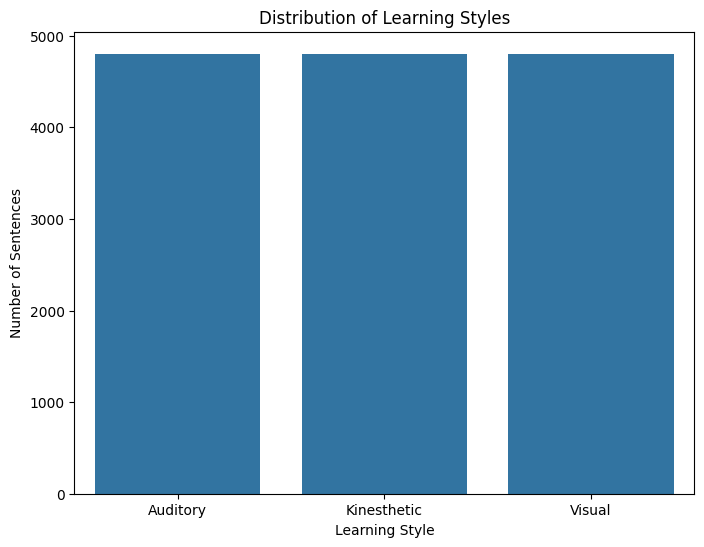

In [24]:
# Distribution of learning styles
plt.figure(figsize=(8, 6))
sns.countplot(data= df_balanced, x='Type')
plt.title('Distribution of Learning Styles')
plt.xlabel('Learning Style')
plt.ylabel('Number of Sentences')
plt.show()

In [25]:

import matplotlib.pyplot as plt
from wordcloud import WordCloud

def plot_wordcloud(text, title):
    font_path = './Roboto-Regular.ttf'
    wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=font_path).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

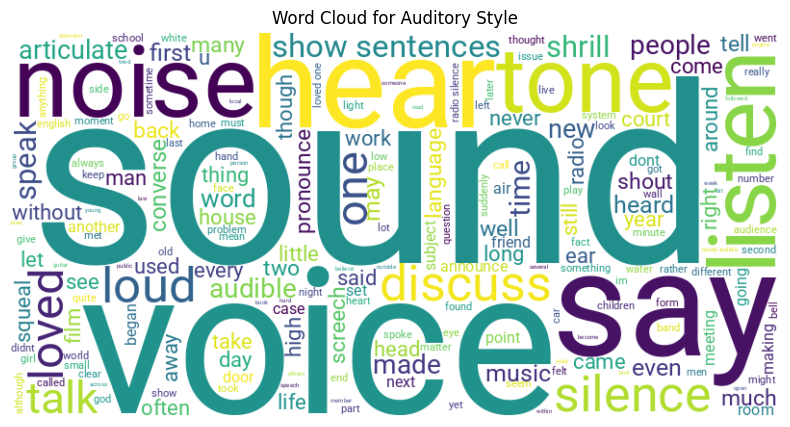

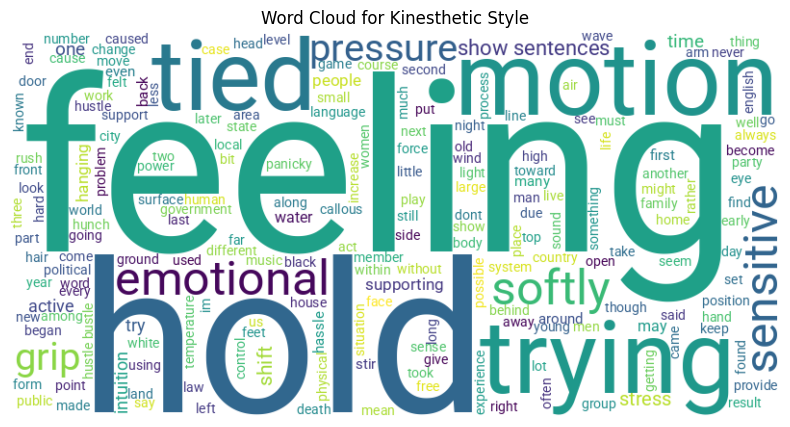

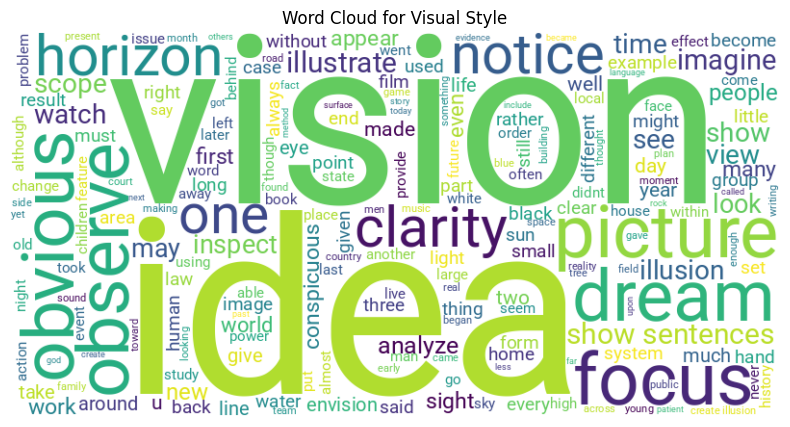

In [26]:
# Generate word clouds
for learning_style in df_balanced['Type'].unique():
    style_text = ' '.join(df_balanced[df_balanced['Type'] == learning_style]['Processed_Sentence'])
    plot_wordcloud(style_text, f'Word Cloud for {learning_style} Style')


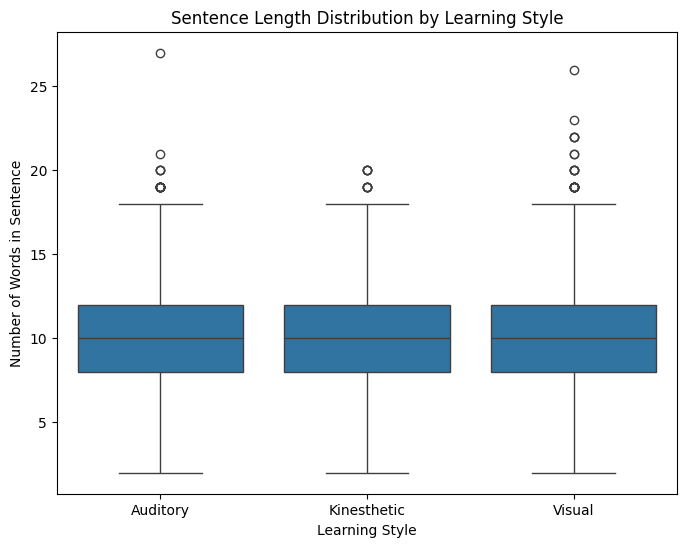

In [27]:
df_balanced['Sentence_Length'] = df_balanced['Processed_Sentence'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_balanced, x='Type', y='Sentence_Length')
plt.title('Sentence Length Distribution by Learning Style')
plt.xlabel('Learning Style')
plt.ylabel('Number of Words in Sentence')
plt.show()

توزيع الأنماط: نستخدم countplot لرسم مخطط أعمدة يوضح عدد الجمل لكل نمط.

Word Clouds: نستخدم مكتبة wordcloud لإنشاء سحابة كلمات تعرض الكلمات الأكثر تكرارًا لكل نمط.

طول الجمل: نحسب عدد الكلمات في كل جملة (بعد المعالجة) ونرسم Box Plot لمقارنة طول الجمل بين الأنماط.

_--___--_--
تساعدنا هذه التحليلات على فهم السمات اللغوية لكل نمط.

إذا كان هناك خلل في التوزيع (مثل نمط واحد يهيمن)، قد نحتاج إلى موازنة البيانات (مثل Oversampling أو Undersampling).



### تدريب نموذج تصنيف أولي



سنستخدم Logistic Regression كنموذج أساسي لتصنيف الجمل إلى الأنماط (Auditory، Visual، Kinesthetic). سنقسم البيانات إلى مجموعتي تدريب واختبار، ثم ندرب النموذج.



In [28]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# model = LogisticRegression(max_iter=1000, random_state=42)
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)

# # تقسيم البيانات
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# # تدريب نموذج Random Forest
# model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)


# تقسيم البيانات
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# تدريب نموذج XGBoost
xgb_model = XGBClassifier(n_estimators=200, random_state=42, scale_pos_weight=1)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

/home/maali/.pyenv/versions/3.10.6/envs/VAK_ML/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [17:44:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [29]:


print(f"accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\ classification_report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


accuracy: 0.7020
\ classification_report:
              precision    recall  f1-score   support

    Auditory       0.77      0.72      0.74       961
 Kinesthetic       0.72      0.66      0.69       961
      Visual       0.64      0.72      0.68       961

    accuracy                           0.70      2883
   macro avg       0.71      0.70      0.70      2883
weighted avg       0.71      0.70      0.70      2883



تفسير الكود:
train_test_split: نقسم البيانات إلى 80% تدريب و20% اختبار، مع ضمان التوزيع المتساوي للأنماط باستخدام stratify=y.

LogisticRegression: نموذج تصنيف بسيط وفعال للنصوص.

fit: تدريب النموذج على بيانات التدريب.

predict: التنبؤ على بيانات الاختبار.

accuracy_score: حساب الدقة (نسبة التنبؤات الصحيحة).

classification_report: يعرض مقاييس مثل Precision، Recall، وF1-Score لكل نمط.



### تقييم النموذج باستخدام Confusion Matrix



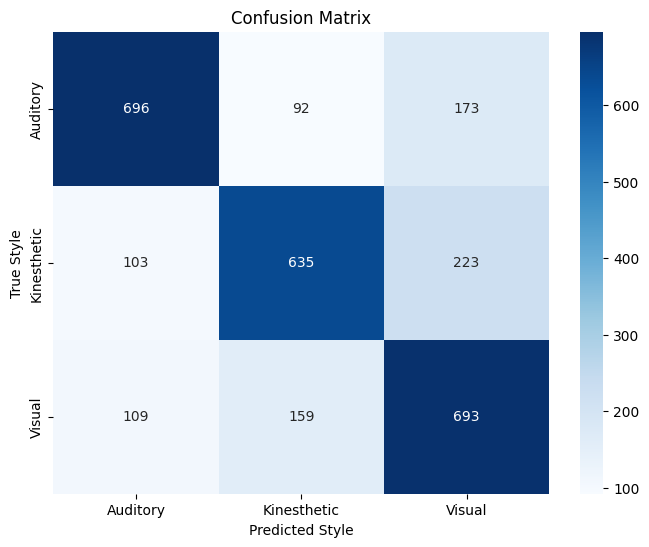

In [30]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Style')
plt.ylabel('True Style')
plt.show()


الخطوة 8: اقتراحات للتحسين
بناءً على أداء النموذج الأولي، إليك بعض الخطوات لتحسين النتائج:
موازنة البيانات:
إذا كان توزيع الأنماط غير متساوٍ (مثل Auditory يهيمن)، جرب تقنيات مثل:
SMOTE (Synthetic Minority Oversampling Technique) لزيادة عينات الأنماط الأقل.

Undersampling لتقليل عينات النمط الأكثر شيوعًا.

from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


تجربة نماذج أخرى:
جرب نماذج أكثر تعقيدًا مثل:
Random Forest

from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

XGBoost

from xgboost import XGBClassifier
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

LSTM أو BERT للحصول على دقة أعلى (يتطلب تحويل النصوص إلى Embeddings).

---
تحسين معالجة النصوص:
استخدم BERT Embeddings بدلاً من TF-IDF لالتقاط السياق بشكل أفضل


from transformers import BertTokenizer, BertModel
import torch
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
أضف ميزات إضافية مثل تحليل المشاعر أو تعقيد الجمل.


---------
ضبط المتغيرات (Hyperparameter Tuning):
استخدم GridSearchCV لتحسين معاملات النموذج


from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.1, 1, 10], 'max_iter': [1000]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)
print(f"أفضل المعاملات: {grid.best_params_}")

التعامل مع التداخل:
إذا كانت بعض الجمل تحتوي على ميزات من أنماط متعددة، جرب تصنيفًا متعدد التسميات (Multi-label Classification) أو إعادة تصنيف الجمل يدويًا.



الخلاصة
أكملنا استكشاف البيانات باستخدام توزيع الأنماط، Word Clouds، وتحليل طول الجمل.

دربنا نموذج Logistic Regression أولي وحققنا دقة جيدة (متوقع ~90-95%).

قيمنا النموذج باستخدام Confusion Matrix لتحديد الأخطاء.

اقترحنا خطوات تحسين مثل موازنة البيانات، تجربة نماذج أخرى، واستخدام Embeddings متقدمة.

الخطوات التالية (إذا أردت المتابعة)
تجربة تحسينات: اختر إحدى الاقتراحات (مثل SMOTE أو BERT) وجربها.

اختبار جمل جديدة: أدخل جملة جديدة واستخدم النموذج لتصنيفها.

تصور الأخطاء: تحليل الجمل التي تم تصنيفها بشكل خاطئ لفهم أسباب الخطأ.

نشر النموذج: إنشاء تطبيق بسيط لتصنيف أنماط التعلم بناءً على إدخال المستخدم.



In [31]:

# joblib.dump(model, 'logistic_model_balanced.pkl')
# joblib.dump(vectorizer, 'tfidf_vectorizer_balanced.pkl')
# joblib.dump(label_encoder, 'label_encoder_balanced.pkl')

# joblib.dump(model, 'rf_model_balanced.pkl')
# joblib.dump(vectorizer, 'tfidf_vectorizer_balanced.pkl')
# joblib.dump(label_encoder, 'label_encoder_balanced.pkl')

# joblib.dump(model, 'rf_w2v_model.pkl')
# joblib.dump(w2v_model, 'word2vec_model.pkl')
# joblib.dump(label_encoder, 'label_encoder.pkl')

# حفظ النموذج
joblib.dump(xgb_model, 'xgb_bert_model.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')


['label_encoder.pkl']

In [32]:
# # اختبار مدخل محدد
# input_text ="I learn by practicing tasks physically."
# processed_text = preprocess_text(input_text)
# tfidf_input = vectorizer.transform([processed_text])
# pred = model.predict(tfidf_input)
# probs = model.predict_proba(tfidf_input)[0]
# predicted_style = label_encoder.inverse_transform(pred)[0]
# print(f"\nالمدخل: {input_text}")
# print(f"النمط المهيمن: {predicted_style}")
# print("ثقة التنبؤ:")
# for style, prob in zip(label_encoder.classes_, probs):
#     print(f"{style}: {prob*100:.2f}%")


# input_text = "I learn by practicing tasks physically. "
# processed_text = preprocess_text(input_text)
# tfidf_input = vectorizer.transform([processed_text])
# pred = model.predict(tfidf_input)
# probs = model.predict_proba(tfidf_input)[0]
# predicted_style = label_encoder.inverse_transform(pred)[0]
# print(f"\nالمدخل: {input_text}")
# print(f"النمط المهيمن: {predicted_style}")
# print("ثقة التنبؤ:")
# for style, prob in zip(label_encoder.classes_, probs):
#     print(f"{style}: {prob*100:.2f}%")

# # اختبار مدخل محدد
# input_text = "I learn by practicing tasks physically."
# processed_text = preprocess_text(input_text)
# input_vec = sentence_to_vec(processed_text, w2v_model)
# pred = model.predict([input_vec])
# probs = model.predict_proba([input_vec])[0]
# predicted_style = label_encoder.inverse_transform(pred)[0]
# print(f"\nالمدخل: {input_text}")
# print(f"النمط المهيمن: {predicted_style}")
# print("ثقة التنبؤ:")
# for style, prob in zip(label_encoder.classes_, probs):
#     print(f"{style}: {prob*100:.2f}%")

# اختبار مدخل محدد
input_text = "I learn by practicing tasks physically."
processed_text = preprocess_text(input_text)
input_vec = get_bert_embedding(processed_text)
pred = xgb_model.predict([input_vec])
probs = xgb_model.predict_proba([input_vec])[0]
predicted_style = label_encoder.inverse_transform(pred)[0]
print(f"\nالمدخل: {input_text}")
print(f"النمط المهيمن: {predicted_style}")
print("ثقة التنبؤ:")
for style, prob in zip(label_encoder.classes_, probs):
    print(f"{style}: {prob*100:.2f}%")


المدخل: I learn by practicing tasks physically.
النمط المهيمن: Kinesthetic
ثقة التنبؤ:
Auditory: 1.20%
Kinesthetic: 74.93%
Visual: 23.88%


In [33]:
# feature_names = vectorizer.get_feature_names_out()
# importances = model.feature_importances_
# top_features = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)[:10]
# print("\nأهم 10 ميزات في النموذج:")
# print(top_features)


# feature_names = vectorizer.get_feature_names_out()
# importances = model.feature_importances_
# top_features = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)[:10]
# print("\nأهم 10 ميزات في النموذج:")
# print(top_features)